In [1]:
import gdown
gdown.download("https://drive.google.com/file/d/1Z3RNNc8Hqa3KYIGCuYpp0Ubgfx5-1DYC/view?usp=drive_link", "dataset.zip", fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1Z3RNNc8Hqa3KYIGCuYpp0Ubgfx5-1DYC
To: /home/tommy/workspace/uni/bigdata/ex1/dataset.zip
100%|██████████| 20.6M/20.6M [00:00<00:00, 21.7MB/s]


'dataset.zip'

In [2]:
!unzip dataset.zip

Archive:  dataset.zip
  inflating: AirPollutionSeoul/Measurement_summary.csv  
  inflating: AirPollutionSeoul/Original Data/Measurement_info.csv  
  inflating: AirPollutionSeoul/Original Data/Measurement_item_info.csv  
  inflating: AirPollutionSeoul/Original Data/Measurement_station_info.csv  


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Question 1

The databse source can be found here:
https://www.kaggle.com/datasets/bappekim/air-pollution-in-seoul/data


In [4]:
measurement_info=pd.read_csv("AirPollutionSeoul/Original Data/Measurement_info.csv")
measurement_info.head()

,Measurement date,Station code,Item code,Average value,Instrument status
0,2017-01-01 00:00,101,1,0.004,0
1,2017-01-01 00:00,101,3,0.059,0
2,2017-01-01 00:00,101,5,1.200,0
3,2017-01-01 00:00,101,6,0.002,0
4,2017-01-01 00:00,101,8,73.000,0


In [6]:
measurement_item_info=pd.read_csv("AirPollutionSeoul/Original Data/Measurement_item_info.csv")
measurement_item_info.head()

,Item code,Item name,Unit of measurement,Good(Blue),Normal(Green),Bad(Yellow),Very bad(Red)
0,1,SO2,ppm,0.02,0.05,0.15,1.0
1,3,NO2,ppm,0.03,0.06,0.20,2.0
2,5,CO,ppm,2.00,9.00,15.00,50.0
3,6,O3,ppm,0.03,0.09,0.15,0.5
4,8,PM10,Mircrogram/m3,30.00,80.00,150.00,600.0


In [7]:
measurement_station_info=pd.read_csv("AirPollutionSeoul/Original Data/Measurement_station_info.csv")
measurement_station_info.head()

,Station code,Station name(district),Address,Latitude,Longitude
0,101,Jongno-gu,"19, Jong-ro 35ga-gil, Jongno-gu, Seoul, Republ...",37.572016,127.005008
1,102,Jung-gu,"15, Deoksugung-gil, Jung-gu, Seoul, Republic o...",37.564263,126.974676
2,103,Yongsan-gu,"136, Hannam-daero, Yongsan-gu, Seoul, Republic...",37.540033,127.004850
3,104,Eunpyeong-gu,"215, Jinheung-ro, Eunpyeong-gu, Seoul, Republi...",37.609823,126.934848
4,105,Seodaemun-gu,"32, Segeomjeong-ro 4-gil, Seodaemun-gu, Seoul,...",37.593742,126.949679


## Question 2

# TODO: make sure this is in the format that they wanted

A schema for the air pollution measurements in Seoul dataset will look as follows:

### 1. Measurement Info Table

This table stores the air pollution measurements. Queries on this table are likely to be based on date, station code, and item code.

- **Table Name**: `measurement_info`
- **Primary Key**:
  - **Partition Key**: `station_code`
  - **Clustering Columns**: `measurement_date`, `item_code`
- **Columns**:
  - `measurement_date` (timestamp)
  - `station_code` (int)
  - `item_code` (int)
  - `average_value` (float)
  - `instrument_status` (int)

This schema will efficiently support queries filtering by a specific station and then ordering or filtering further by date and pollutant item.

### 2. Measurement Item Info Table

This table contains information about the measurement items (pollutants).

- **Table Name**: `measurement_item_info`
- **Primary Key**:
  - **Partition Key**: `item_code`
- **Columns**:
  - `item_code` (int)
  - `item_name` (text)
  - `unit_of_measurement` (text)
  - `good_blue` (float)
  - `normal_green` (float)
  - `bad_yellow` (float)
  - `very_bad_red` (float)

Since the queries on this table will likely be to retrieve information about a specific pollutant, the item code is a suitable partition key.

### 3. Measurement Station Info Table

This table stores information about the measurement stations.

- **Table Name**: `measurement_station_info`
- **Primary Key**:
  - **Partition Key**: `station_code`
- **Columns**:
  - `station_code` (int)
  - `station_name` (text)
  - `address` (text)
  - `latitude` (float)
  - `longitude` (float)

Queries on this table will likely involve looking up information based on the station code, making it a suitable partition key.

## Question 3


In [54]:
# Kill any running previous instance
! docker kill ex1_cassandra || true

# Setting up cassandra instance using docker with local persistent storage under the persistent_data folder.
# The cassandra.yaml file is also mounted to the container to allow for configuration changes.
! docker run --rm -d --name ex1_cassandra -p 9042:9042 -v `pwd`/cassandra.yaml:/etc/cassandra/cassandra.yaml -v `pwd`/persistent_data:/var/lib/cassandra cassandra 

Error response from daemon: Cannot kill container: ex1_cassandra: No such container: ex1_cassandra
c447c0d21c35353647278124735a7673f4c5fccdb48fae8ee0ed117a2941e492


In [18]:
from cassandra.cluster import Cluster
from cassandra.query import BatchStatement
from cassandra.query import SimpleStatement

# Setup Cassandra Connection
cluster = Cluster(['127.0.0.1'])
session = cluster.connect()


In [19]:

# Create Keyspace and Tables

session.execute("""
    CREATE KEYSPACE IF NOT EXISTS ex1_keyspace WITH replication = {
        'class': 'SimpleStrategy', 'replication_factor': '3'
    }
""")

session.set_keyspace('ex1_keyspace')

session.execute("""
    CREATE TABLE IF NOT EXISTS measurement_info (
        station_code int,
        measurement_date timestamp,
        item_code int,
        average_value float,
        instrument_status int,
        PRIMARY KEY (station_code, measurement_date, item_code)
    )
""")

session.execute("""
    CREATE TABLE IF NOT EXISTS measurement_item_info (
        item_code int PRIMARY KEY,
        item_name text,
        unit_of_measurement text,
        good_blue float,
        normal_green float,
        bad_yellow float,
        very_bad_red float
    )
""")

session.execute("""
    CREATE TABLE IF NOT EXISTS measurement_station_info (
        station_code int PRIMARY KEY,
        station_name text,
        address text,
        latitude float,
        longitude float
    )
""")

batch_size = 500


In [ ]:
# Ingestion of measurement_item_info

def clean_and_transform_measurement_item_info(df):
    df['Item code'] = df['Item code'].astype(int)
    df['Item name'] = df['Item name'].astype(str)
    df['Unit of measurement'] = df['Unit of measurement'].astype(str)
    df['Good(Blue)'] = df['Good(Blue)'].astype(float)
    df['Normal(Green)'] = df['Normal(Green)'].astype(float)
    df['Bad(Yellow)'] = df['Bad(Yellow)'].astype(float)
    df['Very bad(Red)'] = df['Very bad(Red)'].astype(float)
    return df

measurement_item_info_normalized = clean_and_transform_measurement_item_info(measurement_item_info)

insert_stmt_measurement_item_info = session.prepare("""
    INSERT INTO measurement_item_info (item_code, item_name, unit_of_measurement, good_blue, normal_green, bad_yellow, very_bad_red)
    VALUES (?, ?, ?, ?, ?, ?, ?)
""")

batch = BatchStatement()
for index, row in measurement_item_info_normalized.iterrows():
    batch.add(insert_stmt_measurement_item_info, (row['Item code'], row['Item name'], row['Unit of measurement'], row['Good(Blue)'], row['Normal(Green)'], row['Bad(Yellow)'], row['Very bad(Red)']))
    if index % batch_size == 0:
        session.execute(batch)
        batch.clear()

session.execute(batch)


In [ ]:
# Ingestion of measurement_station_info

def clean_and_transform_measurement_station_info(df):
    df['Station code'] = df['Station code'].astype(int)
    df['Station name(district)'] = df['Station name(district)'].astype(str)
    df['Address'] = df['Address'].astype(str)
    df['Latitude'] = df['Latitude'].astype(float)
    df['Longitude'] = df['Longitude'].astype(float)
    return df

measurement_station_info_normalized = clean_and_transform_measurement_station_info(measurement_station_info)
insert_stmt_measurement_station_info = session.prepare("""
    INSERT INTO measurement_station_info (station_code, station_name, address, latitude, longitude)
    VALUES (?, ?, ?, ?, ?)
""")

batch = BatchStatement()
for index, row in measurement_station_info_normalized.iterrows():
    batch.add(insert_stmt_measurement_station_info, (row['Station code'], row['Station name(district)'], row['Address'], row['Latitude'], row['Longitude']))
    if index % batch_size == 0:
        session.execute(batch)
        batch.clear()

session.execute(batch)

In [ ]:

# Ingestion of measurement_info

def clean_and_transform_measurement_info(df):
    df['Measurement date'] = pd.to_datetime(df['Measurement date'])
    df['Station code'] = df['Station code'].astype(int)
    df['Item code'] = df['Item code'].astype(int)
    df['Average value'] = df['Average value'].astype(float)
    df['Instrument status'] = df['Instrument status'].astype(int)
    return df

measurement_info_normalized = clean_and_transform_measurement_info(measurement_info)

insert_stmt_measurement_info = session.prepare("""
    INSERT INTO measurement_info (station_code, measurement_date, item_code, average_value, instrument_status)
    VALUES (?, ?, ?, ?, ?)
""")

batch = BatchStatement()
for index, row in measurement_info_normalized.iterrows():
    batch.add(insert_stmt_measurement_info, (row['Station code'], row['Measurement date'], row['Item code'], row['Average value'], row['Instrument status']))
    if index % batch_size == 0:
        session.execute(batch)
        batch.clear()

session.execute(batch)


# Question 4

Starting a `cqlsh` session on the instance:
`docker exec -it ex1_cassandra cqlsh`

Applying the keyspace:
`use ex1_keyspace`

# TODO: showcase more queries with joins

## Question 5

# TODO: add more queries with joins

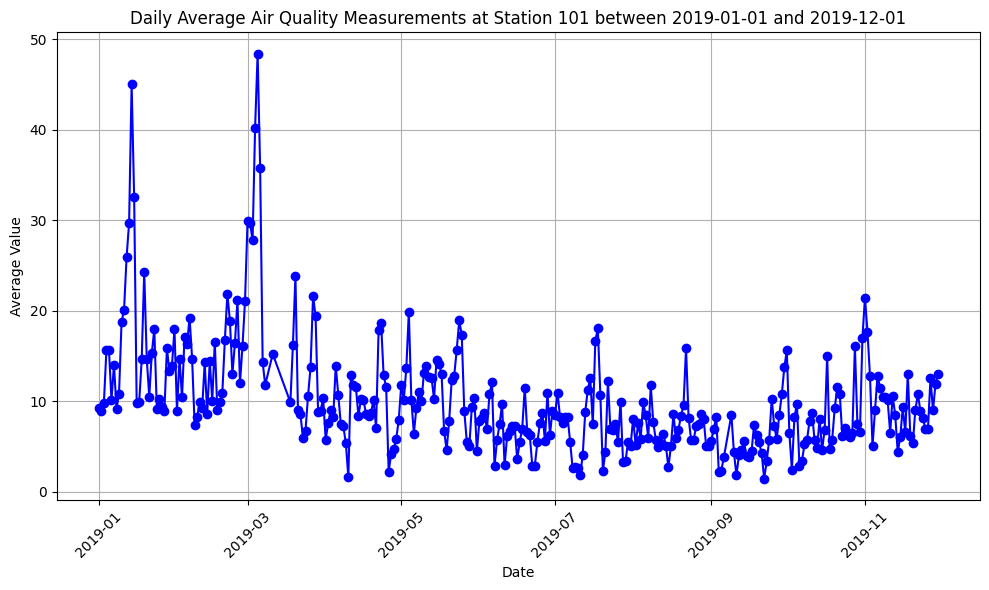

In [ ]:

# Query daily average air quality measurements at station 101 between 2019-01-01 and 2019-12-01
query = """
SELECT measurement_date, average_value FROM measurement_info 
WHERE station_code = 101 AND measurement_date >= '2019-01-01 00:00:00' 
AND measurement_date < '2019-12-01 00:00:00';
"""
statement = SimpleStatement(query, fetch_size=None)
rows = session.execute(statement)
df = pd.DataFrame(list(rows))

# Convert measurement_date to a date (without time) for daily aggregation
df['measurement_date'] = pd.to_datetime(df['measurement_date']).dt.date

# Aggregate by date to get daily average
daily_avg = df.groupby('measurement_date')['average_value'].mean().reset_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(daily_avg['measurement_date'], daily_avg['average_value'], marker='o', linestyle='-', color='b')
plt.title('Daily Average Air Quality Measurements at Station 101 between 2019-01-01 and 2019-12-01')
plt.xlabel('Date')
plt.ylabel('Average Value')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()  # Adjusts plot to ensure everything fits without overlapping
plt.show()

## Question 6

# TODO: this question
